🚀 Execution initialized on cuda
Theta (Center)  | Gamma      | Accuracy  
---------------------------------------------
2.00            | 0.00       | 0.75
2.00            | 0.25       | 0.80
2.00            | 0.50       | 0.80
2.00            | 0.75       | 0.82
2.00            | 1.00       | 0.82
2.00            | 1.50       | 0.75
2.00            | 2.00       | 0.72
2.00            | 3.00       | 0.56
1.00            | 0.00       | 0.71
1.00            | 0.25       | 0.75
1.00            | 0.50       | 0.80
1.00            | 0.75       | 0.80
1.00            | 1.00       | 0.79
1.00            | 1.50       | 0.76
1.00            | 2.00       | 0.68
1.00            | 3.00       | 0.54
0.50            | 0.00       | 0.69
0.50            | 0.25       | 0.79
0.50            | 0.50       | 0.79
0.50            | 0.75       | 0.78
0.50            | 1.00       | 0.79
0.50            | 1.50       | 0.76
0.50            | 2.00       | 0.70
0.50            | 3.00       | 0.55
0.25            

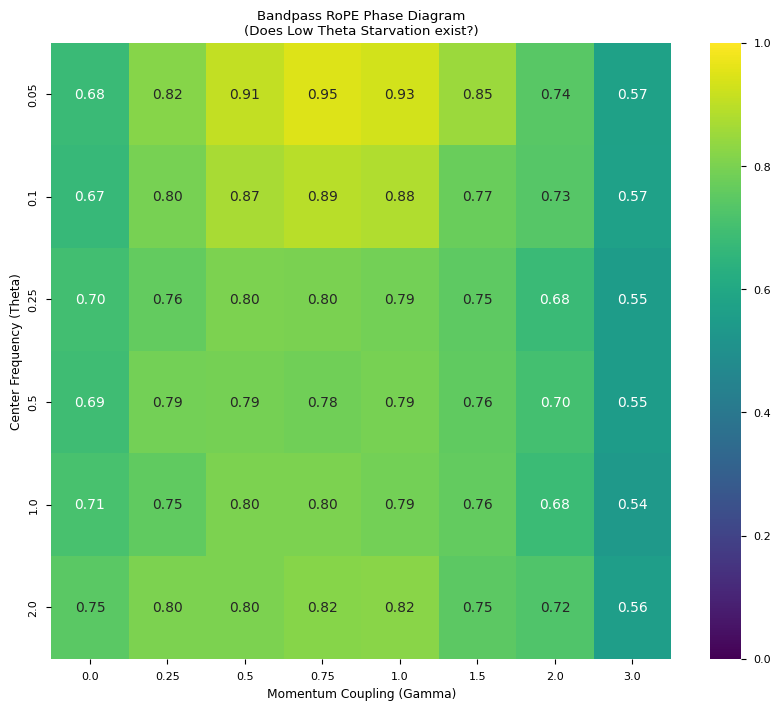

In [ ]:
# ============================================================================
# BANDPASS ROPE EXPERIMENT: THE SPECTRAL WINDOW (Reference: Appendix-F)
# ============================================================================
# A refined "Lab Rat" experiment. Instead of a single frequency (which risks
# geometric resonance cancellation), we provide a narrow "Bandpass" of
# frequencies. This forces the model to operate in a specific spectral regime
# (Low vs High Frequency) while allowing enough diversity to learn the task.
# ============================================================================
## Kingsuk Maitra, Qualcomm AI Cloud Division

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import warnings
import sys

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-paper')

# Robust Device Selection
try:
    import torch_xla.core.xla_model as xm
    DEVICE = xm.xla_device()
    print(f"🚀 Execution initialized on TPU (XLA): {DEVICE}")
except ImportError:
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🚀 Execution initialized on {DEVICE}")

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ----------------------------------------------------------------------------
# 1. BANDPASS ROPE (The Spectral Filter)
# ----------------------------------------------------------------------------

class BandpassRoPE(nn.Module):
    """
    RoPE with a controllable frequency band.
    Generates frequencies linearly spaced between [theta_min, theta_max].
    """
    def __init__(self, dim: int, center_theta: float, bandwidth: float = 0.2, max_len: int = 5000):
        super().__init__()
        self.dim = dim
        self.max_len = max_len

        # Define the Band
        # We spread frequencies around center_theta +/- bandwidth%
        # e.g., if theta=1.0, width=0.2 -> [0.8, 1.2]
        t_min = center_theta * (1.0 - bandwidth)
        t_max = center_theta * (1.0 + bandwidth)

        # Linear space of frequencies for the head dimension
        # Shape: [Dim/2]
        inv_freq = torch.linspace(t_min, t_max, steps=dim//2)
        self.register_buffer('inv_freq', inv_freq)

        # Cache
        self.cos_cached = None
        self.sin_cached = None
        self.cached_len = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [Batch, SeqLen, Heads, HeadDim]
        seq_len = x.shape[1]
        device = x.device

        if self.cos_cached is None or seq_len > self.cached_len:
            self.cached_len = max(seq_len, self.max_len)
            t = torch.arange(self.cached_len, device=device).float()
            freqs = torch.outer(t, self.inv_freq) # [Len, Dim/2]

            # No concatenation trick here, direct mapping
            emb = freqs
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]

        cos = self.cos_cached[:, :seq_len, :, :]
        sin = self.sin_cached[:, :seq_len, :, :]

        x1 = x[..., :self.dim//2]
        x2 = x[..., self.dim//2:]

        return torch.cat((x1 * cos - x2 * sin, x1 * sin + x2 * cos), dim=-1)

# ----------------------------------------------------------------------------
# 2. RIGOROUS MOMENTUM ATTENTION ARCHITECTURE
# ----------------------------------------------------------------------------

class MomentumAttention(nn.Module):
    """
    Strict implementation of the Paper 5/6 derivation:
    1. Shared Weights (q, k)
    2. RoPE applied ONCE to position
    3. Momentum = Difference of Rotated Vectors
    """
    def __init__(self, d_model: int, n_heads: int, gamma: float, center_theta: float):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_head = d_model // n_heads
        self.n_heads = n_heads
        self.gamma = gamma
        self.scale = 1.0 / math.sqrt(self.d_head)

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        # The Bandpass filter
        self.rope = BandpassRoPE(self.d_head, center_theta)

    def forward(self, x: torch.Tensor, mask=None):
        B, L, D = x.shape

        # 1. Project
        q = self.W_q(x).reshape(B, L, self.n_heads, self.d_head)
        k = self.W_k(x).reshape(B, L, self.n_heads, self.d_head)
        v = self.W_v(x).reshape(B, L, self.n_heads, self.d_head)

        # 2. Apply RoPE (Position Encoding)
        q_rot = self.rope(q)
        k_rot = self.rope(k)

        # 3. Compute Kinematic Momentum (High-Pass Filter)
        # p_t = R_t x_t - R_{t-1} x_{t-1}
        p_q = torch.zeros_like(q_rot)
        p_k = torch.zeros_like(k_rot)

        if L > 1:
            p_q[:, 1:] = q_rot[:, 1:] - q_rot[:, :-1]
            p_k[:, 1:] = k_rot[:, 1:] - k_rot[:, :-1]

        # 4. Augmentation (Symplectic Shear)
        q_hat = q_rot + self.gamma * p_q
        k_hat = k_rot + self.gamma * p_k

        # 5. Attention Mechanism
        # Transpose to [B, H, L, D] for dot product
        q_hat = q_hat.transpose(1, 2)
        k_hat = k_hat.transpose(1, 2)
        v_t   = v.transpose(1, 2)

        scores = torch.matmul(q_hat, k_hat.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v_t)

        return self.W_o(out.transpose(1, 2).reshape(B, L, D))

# ----------------------------------------------------------------------------
# 3. EXPERIMENT EXECUTION
# ----------------------------------------------------------------------------

class ARDataset(Dataset):
    def __init__(self, n, vocab, length):
        self.data = []
        for _ in range(n):
            keys = torch.randperm(vocab // 2)[:length]
            vals = torch.randint(vocab // 2, vocab, (length,))
            seq = torch.zeros(length * 2 + 1, dtype=torch.long)

            # Correct Interleaved Indexing
            seq[0 : 2*length : 2] = keys
            seq[1 : 2*length : 2] = vals

            # Query
            idx = torch.randint(0, length, (1,)).item()
            seq[-1] = keys[idx]
            self.data.append((seq, vals[idx]))

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def run_bandpass_sweep():
    # Sweep Configuration
    # Gamma: From 0 (Vanilla) to 3.0 (High Momentum)
    gammas = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]

    # Frequencies (Thetas):
    # High Freq (~3.0) to Low Freq (~0.1)
    # Testing the hypothesis: Low Freq requires High Gamma
    thetas = [2.0, 1.0, 0.5, 0.25, 0.1, 0.05]

    results = []

    print(f"{'Theta (Center)':<15} | {'Gamma':<10} | {'Accuracy':<10}")
    print("-" * 45)

    for theta in thetas:
        for gamma in gammas:
            # Re-initialize model for each point in the phase diagram
            model = nn.Sequential(
                nn.Embedding(128, 64),
                MomentumAttention(64, 4, gamma, theta),
                nn.LayerNorm(64),
                nn.Linear(64, 128)
            ).to(DEVICE)

            opt = torch.optim.Adam(model.parameters(), lr=2e-3)
            # Chain Length 8 is hard enough to require attention, short enough to train fast
            ds = ARDataset(1500, 128, 8)
            dl = DataLoader(ds, batch_size=64, shuffle=True, drop_last=True)

            # Training Loop (Brief but sufficient for AR)
            model.train()
            for ep in range(6):
                for x, y in dl:
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    logits = model(x)[:, -1]
                    loss = F.cross_entropy(logits, y)
                    opt.zero_grad(); loss.backward();

                    if 'xla' in str(DEVICE):
                        import torch_xla.core.xla_model as xm
                        xm.optimizer_step(opt)
                    else:
                        opt.step()

            # Evaluation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for x, y in dl: # Reuse dataloader for quick check
                    x, y = x.to(DEVICE), y.to(DEVICE)
                    pred = model(x)[:, -1].argmax(-1)
                    correct += (pred == y).sum().item()
                    total += y.size(0)
            acc = correct / total

            print(f"{theta:<15.2f} | {gamma:<10.2f} | {acc:.2f}")
            results.append({'Theta': theta, 'Gamma': gamma, 'Accuracy': acc})

            # Cleanup
            del model, opt
            if torch.cuda.is_available(): torch.cuda.empty_cache()

    return pd.DataFrame(results)

if __name__ == "__main__":
    set_seed(42)
    df = run_bandpass_sweep()

    # Visualization: The Phase Diagram
    plt.figure(figsize=(10, 8))
    piv = df.pivot(index='Theta', columns='Gamma', values='Accuracy')

    # We want low theta at the bottom
    piv = piv.sort_index(ascending=True)

    sns.heatmap(piv, annot=True, fmt=".2f", cmap="viridis", vmin=0, vmax=1.0)
    plt.title("Bandpass RoPE Phase Diagram\n(Does Low Theta Starvation exist?)")
    plt.ylabel("Center Frequency (Theta)")
    plt.xlabel("Momentum Coupling (Gamma)")
    plt.show()